In [47]:
# tf2 environment
import os
import glob
import zipfile
import numpy as np

import matplotlib.pyplot as plt


In [49]:

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # No normalization want to keep values from -1 to 1, only converts to float32
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [50]:
# Folder "intra" consists of MRI scans from intra-registration and "inter" from inter-registration pairs.

path = '/home/andjela/Documents/intra-inter-ddfs'
intra_scan_paths = glob.glob(f"{path}/intra/**/logJacobian.nii.gz", recursive=True)

inter_scan_paths = glob.glob(f"{path}/inter/**/logJacobian.nii.gz", recursive=True)

print("MRI scans with intra log Jacobian: " + str(len(intra_scan_paths)))
print("MRI scans with inter log Jacobian: " + str(len(inter_scan_paths)))

nbr_intra_pairs = len(intra_scan_paths)
nbr_inter_pairs = len(inter_scan_paths)


MRI scans with intra log Jacobian: 434
MRI scans with inter log Jacobian: 421


## Overlap


In [89]:

# Set a random seed for reproducibility
random_state = 42
np.random.seed(random_state)  # You can use any integer value

# Read and process the scans only when the train, val, test sets are selected.
# Each scan is then resized across height, width, and depth and rescaled.
intra_scans = np.array(intra_scan_paths)
inter_scans = np.array(inter_scan_paths)

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

# Number of indices to be selected to match the no_overlap training
num_indices = 279

# Randomly select indices from the first 434 elements (intra part)
first_indices = np.random.choice(nbr_intra_pairs, size=num_indices // 2, replace=False)

# Randomly select indices from the last 421 elements
last_indices = np.random.choice(range(nbr_intra_pairs, len(y)), size=num_indices - len(first_indices), replace=False)

# Concatenate both sets of indices
selected_indices = np.concatenate((first_indices, last_indices))

# Shuffle the indices using the random state
rng = np.random.default_rng(random_state)
rng.shuffle(selected_indices)

selected_train_paths = [X[i] for i in selected_indices]
train_data = np.array([process_scan(path) for path in selected_train_paths])
y_data = y[selected_indices]

print(y_data)


[0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1
 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1
 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0
 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0
 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1
 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1]


## No Overlap

In [51]:
def read_tsv_and_create_dict(file_path):
    participant_mapping = {}
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Check if the participant_id is already in the mapping, if not, assign it a unique identifier
            if participant_id not in participant_mapping:
                unique_id = len(participant_mapping)
                participant_mapping[participant_id] = {'id': unique_id, 'scan_ids': []}
            
            # Append the scan_id to the participant's list
            participant_mapping[participant_id]['scan_ids'].append(scan_id)
            # Append the age
    
    return participant_mapping

In [52]:
import pandas as pd
def read_tsv_and_create_dataframe(file_path):
    participant_data = []
    
    with open(file_path, 'r') as file:
        header = file.readline()  # Skip the header line
        for line in file:
            participant_id, sub_id_bids, scan_id, session, age, sex, group = line.strip().split('\t')
            
            # Convert age to float
            age = float(age)
            
            # Append data to participant_data list
            participant_data.append([participant_id, scan_id, age, sex])
            
    # Create a DataFrame with the participant data
    columns = ['participant_id', 'scan_id', 'age', 'sex']
    df = pd.DataFrame(participant_data, columns=columns)
    
    return df

In [53]:
# Specify the path to your TSV file
file_path = '/home/andjela/Documents/intra-inter-ddfs/src/participants.tsv'

# Call the function to create the dictionary for all 64 patients
participant_mapping = read_tsv_and_create_dict(file_path)

# Obtain dictionnary with subject, scan_id, age and sex
full_df = read_tsv_and_create_dataframe(file_path)


In [54]:
def find_scan_ids(name):
    #Outputs patient number, moving and fixed image scanID as strings for further analysis
    #Possible folder name pairs are below with each string differing in length
    # name = 'CL_Dev_004_CL_Dev_008'
    # name1 = 'CL_Dev_004_PS15_048'
    # name2 = 'PS15_048_CL_Dev_004'
    # name3 = 'PS15_048_PS17_017'
    # name4 = 'PS16_058_PS1183-10-1'

    #idx contains a list of strings of a given name
    idx = [s for s in name.split("_")]
    

    if len(idx) == 6:
        
        mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
        fix = f'{idx[3]}_{idx[4]}_{idx[5]}'
        return(mov, fix)

    elif len(idx) == 5:
        if 'CL' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}_{idx[2]}'
            fix = f'{idx[3]}_{idx[4]}'
            
            return(mov, fix)
        elif 'PS' in idx[0]:
            mov = f'{idx[0]}_{idx[1]}'
            fix = f'{idx[2]}_{idx[3]}_{idx[4]}'
            
            return(mov, fix)

    elif len(idx) == 4:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}_{idx[3]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' not in idx[2]:
        mov = f'{idx[0]}'
        fix = f'{idx[1]}_{idx[2]}'
        return(mov, fix)

    elif len(idx) == 3 and '-' in idx[2]:
        mov = f'{idx[0]}_{idx[1]}'
        fix = f'{idx[2]}'
        return(mov, fix)

    else:
        print('Not a corresponding folder name', name)

In [55]:
all_participant_ids = []
all_participant_ids_and_scan_ids = []

all_paths = np.concatenate((intra_scan_paths, inter_scan_paths), axis=0)

# Iterate over the intra and inter _scan_paths
for path in all_paths:
    # Extract the scan_id from the path
    scan_ids = path.split('/')[-2]
    scan_id_1, scan_id_2 = find_scan_ids(scan_ids)
    
    # Find participant_ids for scan_id_1 and scan_id_2
    participant_id_1 = None
    participant_id_2 = None

    for participant_id, info in participant_mapping.items():
        if scan_id_1 in info['scan_ids']:
            participant_id_1 = participant_id
        if scan_id_2 in info['scan_ids']:
            participant_id_2 = participant_id

    # Create pairs
    if participant_id_1 is not None and participant_id_2 is not None:
        all_participant_ids.append((participant_id_1, participant_id_2))
        all_participant_ids_and_scan_ids.append(((participant_id_1, participant_id_2), (scan_id_1, scan_id_2)))

print("all_participant_ids:", all_participant_ids)
print("all_participant_ids_and_scan_ids:", all_participant_ids_and_scan_ids)
print('Number of pairs in total (both intra and inter):', len(all_participant_ids))


all_participant_ids: [('10077', '10077'), ('10087', '10087'), ('10010', '10010'), ('10010', '10010'), ('10056', '10056'), ('10022', '10022'), ('10009', '10009'), ('10137', '10137'), ('10010', '10010'), ('10032', '10032'), ('10087', '10087'), ('10110', '10110'), ('10025', '10025'), ('10117', '10117'), ('10117', '10117'), ('10061', '10061'), ('10109', '10109'), ('10065', '10065'), ('10044', '10044'), ('10094', '10094'), ('10007', '10007'), ('10021', '10021'), ('10109', '10109'), ('10117', '10117'), ('10137', '10137'), ('10065', '10065'), ('10054', '10054'), ('10096', '10096'), ('10021', '10021'), ('10077', '10077'), ('10137', '10137'), ('10054', '10054'), ('10096', '10096'), ('10117', '10117'), ('10064', '10064'), ('10096', '10096'), ('10090', '10090'), ('10104', '10104'), ('10042', '10042'), ('10089', '10089'), ('10059', '10059'), ('10049', '10049'), ('10136', '10136'), ('10010', '10010'), ('10025', '10025'), ('10047', '10047'), ('10136', '10136'), ('10021', '10021'), ('10046', '10046')

In [56]:
import random 

def shuffle_keys(dictionary, random_seed):
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    # Extract the keys from the dictionary
    keys = list(dictionary.keys())
    
    # Shuffle the keys
    random.shuffle(keys)
    
    # Create a new dictionary with shuffled keys
    shuffled_dict = {key: dictionary[key] for key in keys}
    
    return shuffled_dict

In [57]:
import random

def custom_split_indices(data, ratio, nbr_sets, random_state=None):


    # Create dictionaries to track subjects by participant_id
    indices_by_subject = {}
    
    # Define a list to hold the sets
    all_sets = [set() for _ in range(nbr_sets)]
    
    
    # Iterate through the data and group indices by participant_id (subject_number)
    for i, (participant_id_1, participant_id_2) in enumerate(data):
        if participant_id_1 not in indices_by_subject:
            indices_by_subject[participant_id_1] = []
        
        if participant_id_2 not in indices_by_subject:
            indices_by_subject[participant_id_2] = []
            
        
        indices_by_subject[participant_id_1].append(i)
        if participant_id_2 != participant_id_1:
            indices_by_subject[participant_id_2].append(i)

    # Shuffle all subject keys in the created dictionnary mapping indices
    if random_state is not None:
        shuffled_indices_by_subject = shuffle_keys(indices_by_subject, random_state)

    wanted_ratios = [ratio] * nbr_sets
    iteration = 0
    # Iterate through the subjects, shuffling the order of subjects for each participant_id (subject)
    for subject, indices in shuffled_indices_by_subject.items():
        # print(f"Subject: {subject}")
        iteration += 1  # Increment iteration count
        subject_overlapping = []  # Overlapping for each subject
        for a_set in all_sets:
            overlapping = bool(a_set.intersection(set(indices)))
            subject_overlapping.append(overlapping)

        # Skip that pair if there's overlapping with at least 2 sets, if there is only 1, then update indices where it overlaps, else if there are no
        # overlaps, choose the less populated set to be updated
        if sum(subject_overlapping) == 1:
            for i, a_set in enumerate(all_sets):
                if subject_overlapping[i]:
                    a_set.update(set(indices))
                    break
            continue
        elif sum(subject_overlapping) >= 2:
            continue

        else:
        
            total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
            if total_indices_all_sets == 0:
                all_sets[0].update(set(indices))
                continue

            # Calculate current ratios 
            current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

            # Find where there is the bigger difference between the wanted ratios and the current ratios
            max_idx = np.argmax((np.array(wanted_ratios)-np.array(current_ratios))/np.array(wanted_ratios)) 
            # Update the set based on max_idx
            if max_idx < len(all_sets):
                # Update the set at the specific index indicated by max_idx
                all_sets[max_idx].update(set(indices))
            else:
                print("max_idx is out of range for all_sets")
        # Verify when 2 sets have overlapping indices
        flag = False
        for i in range(len(all_sets)):
            for j in range(i + 1, len(all_sets)):
                if all_sets[i].intersection(all_sets[j]):
                    overlapping = True
                    print(f"Sets {i} and {j} have overlapping indices.")
                    print(subject)
                    flag = True
                    break
                if flag:
                    break
        if flag:
            print(f"Condition met at iteration {iteration}")  # Print the iteration when the condition is met
            break
    
    return all_sets, indices_by_subject

# Example usage:

all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=42)


# Calculate the total length of all indices in all_sets
total_indices = sum(len(a_set) for a_set in all_sets)

print("Total number of indices in all sets:", total_indices)

# Calculate the percentage of indices in each set
for i, a_set in enumerate(all_sets):
    print(len(a_set))
    set_length = len(a_set)
    percentage = (set_length / total_indices) * 100
    print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

overlapping = False

for i in range(len(all_sets)):
    for j in range(i + 1, len(all_sets)):
        if all_sets[i].intersection(all_sets[j]):
            overlapping = True
            print(f"Sets {i} and {j} have overlapping indices.")

if not overlapping:
    print("No sets have overlapping indices.")




Total number of indices in all sets: 351
15
Set 1 has 15 indices, which is 4.27% of the total.
124
Set 2 has 124 indices, which is 35.33% of the total.
19
Set 3 has 19 indices, which is 5.41% of the total.
33
Set 4 has 33 indices, which is 9.40% of the total.
12
Set 5 has 12 indices, which is 3.42% of the total.
53
Set 6 has 53 indices, which is 15.10% of the total.
20
Set 7 has 20 indices, which is 5.70% of the total.
35
Set 8 has 35 indices, which is 9.97% of the total.
13
Set 9 has 13 indices, which is 3.70% of the total.
27
Set 10 has 27 indices, which is 7.69% of the total.
No sets have overlapping indices.


In [58]:
nbr_sets = 10
ratio = 0.1
wanted_ratios =  [ratio] * nbr_sets
lowest_norm = np.linalg.norm(np.array(wanted_ratios))
selected_indices = [[] for _ in range(nbr_sets)]
for i in range(5000):
    all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=i)
    total_indices_all_sets = sum(len(a_set) for a_set in all_sets)
    current_ratios = [len(a_set_indices) / total_indices_all_sets for a_set_indices in all_sets]

    diff_norm = np.linalg.norm(np.array(wanted_ratios) - np.array(current_ratios))
    if diff_norm < lowest_norm:
        lowest_norm = diff_norm
        for x, a_set in enumerate(all_sets):
            selected_indices[x] = a_set
        selected_random_state = i

all_sets, indices_by_subject = custom_split_indices(all_participant_ids, ratio=0.1, nbr_sets=10, random_state=selected_random_state)

# Calculate the total length of all indices in all_sets
total_indices = sum(len(a_set) for a_set in all_sets)

print("Total number of indices in all sets:", total_indices)

# Calculate the percentage of indices in each set
for i, a_set in enumerate(all_sets):
    set_length = len(a_set)
    percentage = (set_length / total_indices) * 100
    print(f"Set {i + 1} has {set_length} indices, which is {percentage:.2f}% of the total.")

print('The chosen random_state should be:', selected_random_state)

Total number of indices in all sets: 279
Set 1 has 30 indices, which is 10.75% of the total.
Set 2 has 18 indices, which is 6.45% of the total.
Set 3 has 26 indices, which is 9.32% of the total.
Set 4 has 33 indices, which is 11.83% of the total.
Set 5 has 21 indices, which is 7.53% of the total.
Set 6 has 26 indices, which is 9.32% of the total.
Set 7 has 27 indices, which is 9.68% of the total.
Set 8 has 34 indices, which is 12.19% of the total.
Set 9 has 35 indices, which is 12.54% of the total.
Set 10 has 29 indices, which is 10.39% of the total.
The chosen random_state should be: 2641


In [59]:
train_indices_list = []
val_indices_list = []
test_indices_list = []

for i in range(10):
    test_indices = list(all_sets[i])  # Set the test set

    # Determine the start of the validation indices based on the test index
    val_start = i * 2 + 1

    val_set_1 = list(all_sets[val_start % 10])  # First validation set
    val_set_2 = list(all_sets[(val_start + 1) % 10])  # Second validation set

    # Train indices are the rest of the sets not used for test and validation
    train_indices = []
    for j in range(10):
        if j not in [i, val_start % 10, (val_start + 1) % 10]:
            train_indices.extend(list(all_sets[j]))

    train_indices_list.append(train_indices)
    val_indices_list.append(val_set_1 + val_set_2)
    test_indices_list.append(test_indices)

    # Use the sets as needed (train, validation, test)
    # For example:
    print(f"Iteration {i + 1}:")
    print("Train sets:", train_indices)
    print("Validation sets:", val_set_1 + val_set_2)
    print("Test set:", test_indices)
    print()



Iteration 1:
Train sets: [641, 772, 773, 774, 709, 456, 714, 651, 78, 145, 723, 854, 534, 280, 26, 794, 347, 475, 350, 31, 288, 416, 744, 554, 111, 306, 372, 246, 311, 504, 121, 122, 702, 384, 66, 387, 454, 265, 585, 213, 536, 665, 734, 738, 298, 682, 237, 430, 687, 622, 433, 438, 378, 571, 707, 838, 519, 392, 843, 652, 588, 532, 725, 726, 791, 474, 540, 285, 670, 480, 34, 420, 617, 362, 623, 690, 691, 505, 699, 828, 453, 713, 650, 524, 460, 527, 847, 401, 591, 787, 471, 476, 800, 608, 164, 804, 614, 39, 484, 683, 625, 563, 692, 501, 503, 56, 444, 512, 581, 327, 458, 844, 721, 340, 85, 788, 663, 537, 282, 602, 541, 671, 351, 482, 229, 742, 743, 679, 41, 105, 491, 108, 302, 751, 560, 756, 821, 696, 633, 317, 446, 577, 642, 706, 580, 644, 777, 267, 76, 781, 16, 144, 851, 469, 662, 22, 664, 792, 730, 279, 732, 728, 731, 545, 550, 615, 42, 492, 109, 46, 367, 307, 437, 57, 250, 381, 640, 65, 129, 775, 711, 139, 141, 782, 784, 465, 789, 797, 607, 546, 163, 38, 426, 811, 171, 370, 371, 628, 1

In [62]:
from sklearn.model_selection import train_test_split
split_nbr = 0
# Read and process the scans only when the train, val, test sets are selected.
# Each scan is then resized across height, width, and depth and rescaled.
intra_scans = np.array(intra_scan_paths)
inter_scans = np.array(inter_scan_paths)

# For the MRI scans having a logJacobian derived from intra reg assign 1, 
# for inter assign 0.
intra_labels = np.array([1 for _ in range(len(intra_scans))])
inter_labels = np.array([0 for _ in range(len(inter_scans))])

X = np.concatenate((intra_scans, inter_scans), axis=0)
y = np.concatenate((intra_labels, inter_labels), axis=0)

# Read and process only the selected paths for the train, val and test sets
selected_train_paths = [X[i] for i in train_indices_list[split_nbr]]
x_train, y_train = np.array([process_scan(path) for path in selected_train_paths]), y[train_indices_list[split_nbr]]
selected_val_paths = [X[i] for i in val_indices_list[split_nbr]]
x_val, y_val = np.array([process_scan(path) for path in selected_val_paths]), y[val_indices_list[split_nbr]]
selected_test_paths = [X[i] for i in test_indices_list[split_nbr]]
x_test, y_test = np.array([process_scan(path) for path in selected_test_paths]), y[test_indices_list[split_nbr]]

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)

Number of samples in train, validation and test are 205, 44 and 30.


## Dataframes for both training schemes

In [76]:
def calculate_average_abs_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values
    abs_values = np.abs(volume)

    # Calculate the average of the absolute values
    average_absolute = np.mean(abs_values)

    return average_absolute

In [77]:
def calculate_average_log_jacobian(volume):
    # Iterate through the image_3d and store the absolute values of all elements in abs_values

    # Calculate the average of the absolute values
    average_absolute = np.mean(volume)

    return average_absolute

In [ ]:

df_279_overlap = pd.DataFrame(columns=['scan_id_1', 'scan_id_2', 'age_interval', 'avg_log_jacobian', 'avg_abs_log_jacobian', 'group'])

for i in selected_indices:
    participant_ids_scan_ids = all_participant_ids_and_scan_ids[i]
    # Intra case
    if participant_ids_scan_ids[0][0] == participant_ids_scan_ids[0][1]:
        group = 'intra'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
        age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        df_279_overlap = df_279_overlap.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'group': group}, ignore_index=True)
    # Inter case
    else:
        group = 'inter'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
        age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        df_279_overlap = df_279_overlap.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'group': group}, ignore_index=True)
    
    index_of_i = int(np.where(selected_indices == i)[0])
    volume = train_data[index_of_i]
    avg_abs_log_jacobian = calculate_average_abs_log_jacobian(volume)
    avg_log_jacobian = calculate_average_log_jacobian(volume)
    # This line gets the row index where 'scan_id_1' and 'scan_id_2' match the specified values
    row_index = df_279_overlap[(df_279_overlap['scan_id_1'] == specific_scan_id_1) & (df_279_overlap['scan_id_2'] == specific_scan_id_2)].index
    # print('ROW', row_index)
    # You can access the index, assuming only one row matches these conditions
    if not row_index.empty:
        row_index_value = row_index[0]
        # Update the 'age_interval' column for the identified row
        df_279_overlap.at[row_index_value, 'avg_abs_log_jacobian'] = avg_abs_log_jacobian
        df_279_overlap.at[row_index_value, 'avg_log_jacobian'] = avg_log_jacobian

    


In [98]:
df_279_overlap.head()

,scan_id_1,scan_id_2,age_interval,avg_log_jacobian,avg_abs_log_jacobian,group
0,PS15_114,PS16_038,0.0195,-0.002225,0.022738,inter
1,PS14_029,PS16_037,1.9444,-0.003046,0.027175,intra
2,PS15_116,PS17_013,1.6195,-0.005817,0.036097,intra
3,PS16_032,PS17_034,1.2611,-0.004114,0.028143,intra
4,PS16_010,PS15_025,0.0028,-0.001846,0.020584,inter


In [ ]:

df_279_no_overlap = pd.DataFrame(columns=['scan_id_1', 'scan_id_2', 'age_interval', 'avg_log_jacobian', 'avg_abs_log_jacobian', 'group'])
# Combine all sets into a single list
combined_list_of_sets = []
for a_set in all_sets:
    combined_list_of_sets.extend(list(a_set))

print(combined_list_of_sets)

for i in combined_list_of_sets:
    participant_ids_scan_ids = all_participant_ids_and_scan_ids[i]
    # Intra case
    if participant_ids_scan_ids[0][0] == participant_ids_scan_ids[0][1]:
        group = 'intra'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
        age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        df_279_no_overlap = df_279_no_overlap.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'group': group}, ignore_index=True)
    # Inter case
    else:
        group = 'inter'
        specific_scan_id_1 = participant_ids_scan_ids[1][0]
        specific_scan_id_2 = participant_ids_scan_ids[1][1]
        # Filter the DataFrame to retrieve the ages for the specific scan IDs
        age_for_scan_id_1 = full_df.loc[full_df['scan_id'] == specific_scan_id_1, 'age'].iloc[0]
        age_for_scan_id_2 = full_df.loc[full_df['scan_id'] == specific_scan_id_2, 'age'].iloc[0]
        age_interval = np.abs(age_for_scan_id_2 - age_for_scan_id_1)
        df_279_no_overlap = df_279_no_overlap.append({'scan_id_1': specific_scan_id_1, 'scan_id_2': specific_scan_id_2, 'age_interval': age_interval, 'group': group}, ignore_index=True)
    if i in train_indices_list[split_nbr]:
        index_of_i = train_indices_list[split_nbr].index(i)
        volume = x_train[index_of_i]
        avg_abs_log_jacobian = calculate_average_abs_log_jacobian(volume)
        avg_log_jacobian = calculate_average_log_jacobian(volume)
        # This line gets the row index where 'scan_id_1' and 'scan_id_2' match the specified values
        row_index = df_279_no_overlap[(df_279_no_overlap['scan_id_1'] == specific_scan_id_1) & (df_279_no_overlap['scan_id_2'] == specific_scan_id_2)].index
        # print('ROW', row_index)
        # You can access the index, assuming only one row matches these conditions
        if not row_index.empty:
            row_index_value = row_index[0]
            # Update the 'age_interval' column for the identified row
            df_279_no_overlap.at[row_index_value, 'avg_abs_log_jacobian'] = avg_abs_log_jacobian
            df_279_no_overlap.at[row_index_value, 'avg_log_jacobian'] = avg_log_jacobian
        else:
            print('Row index train empty')
    elif i in val_indices_list[split_nbr]:
        index_of_i = val_indices_list[split_nbr].index(i)
        volume = x_val[index_of_i]
        avg_abs_log_jacobian = calculate_average_abs_log_jacobian(volume)
        avg_log_jacobian = calculate_average_log_jacobian(volume)
        # This line gets the row index where 'scan_id_1' and 'scan_id_2' match the specified values
        row_index = df_279_no_overlap[(df_279_no_overlap['scan_id_1'] == specific_scan_id_1) & (df_279_no_overlap['scan_id_2'] == specific_scan_id_2)].index
        # print('ROW val', row_index)
        # You can access the index, assuming only one row matches these conditions
        if not row_index.empty:
            row_index_value = row_index[0]
            # Update the 'age_interval' column for the identified row
            df_279_no_overlap.at[row_index_value, 'avg_abs_log_jacobian'] = avg_abs_log_jacobian
            df_279_no_overlap.at[row_index_value, 'avg_log_jacobian'] = avg_log_jacobian
        else:
            print('Row index val empty')
    else:
        index_of_i = test_indices_list[split_nbr].index(i)
        volume = x_test[index_of_i]
        avg_abs_log_jacobian = calculate_average_abs_log_jacobian(volume)
        avg_log_jacobian = calculate_average_log_jacobian(volume)
        # This line gets the row index where 'scan_id_1' and 'scan_id_2' match the specified values
        row_index = df_279_no_overlap[(df_279_no_overlap['scan_id_1'] == specific_scan_id_1) & (df_279_no_overlap['scan_id_2'] == specific_scan_id_2)].index
        # print('ROW test', row_index[0])
        # You can access the index, assuming only one row matches these conditions
        if not row_index.empty:
            row_index_value = row_index[0]
            # Update the 'age_interval' column for the identified row
            df_279_no_overlap.at[row_index_value, 'avg_abs_log_jacobian'] = avg_abs_log_jacobian
            df_279_no_overlap.at[row_index_value, 'avg_log_jacobian'] = avg_log_jacobian
        else:
            print('Row index test empty')

# print(df_279)
    


In [84]:
print(df_279_no_overlap.head())

  scan_id_1 scan_id_2  age_interval avg_log_jacobian avg_abs_log_jacobian  \
0  PS15_041  PS14_134        0.0222        -0.002306             0.022083   
1  PS14_073  PS15_079        0.0028         -0.00276             0.025215   
2  PS15_127  PS14_134        0.0028        -0.002192             0.021543   
3  PS14_134  PS16_009        1.0194        -0.006079             0.035245   
4  PS16_009  PS16_028        0.0084        -0.002768              0.02544   

   group  
0  inter  
1  inter  
2  inter  
3  intra  
4  inter  


# PLOTS

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns

# Read the CSV file
file_path = '/home/andjela/Documents/intra-inter-ddfs/src/3D-image-classification-tutorial/df_279_data.csv'
df_279 = pd.read_csv(file_path)

# Display the first few rows to verify the data was read correctly
print(df_279.head())

  scan_id_1 scan_id_2  age_interval  avg_abs_log_jacobian  group
0  PS15_041  PS14_134        0.0222              0.022083  inter
1  PS14_073  PS15_079        0.0028              0.025215  inter
2  PS15_127  PS14_134        0.0028              0.021543  inter
3  PS14_134  PS16_009        1.0194              0.035245  intra
4  PS16_009  PS16_028        0.0084              0.025440  inter


In [88]:
group_inter = df_279_no_overlap[df_279_no_overlap['group'] == 'inter']
group_intra = df_279_no_overlap[df_279_no_overlap['group'] == 'intra']
print(np.mean(group_inter), np.std(group_inter))
print(np.mean(group_intra), np.std(group_intra))

age_interval            0.013082
avg_log_jacobian       -0.002594
avg_abs_log_jacobian    0.024656
dtype: float64 age_interval            0.007644
avg_log_jacobian        0.000333
avg_abs_log_jacobian    0.002155
dtype: float64
age_interval            1.183177
avg_log_jacobian       -0.003970
avg_abs_log_jacobian    0.028633
dtype: float64 age_interval            0.696398
avg_log_jacobian        0.001518
avg_abs_log_jacobian    0.006536
dtype: float64


/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(ax

age_interval            0.013082
avg_abs_log_jacobian    0.024655
dtype: float64 age_interval            0.007644
avg_abs_log_jacobian    0.002157
dtype: float64
age_interval            1.183177
avg_abs_log_jacobian    0.028633
dtype: float64 age_interval            0.696398
avg_abs_log_jacobian    0.006536
dtype: float64


/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/andjela/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(ax

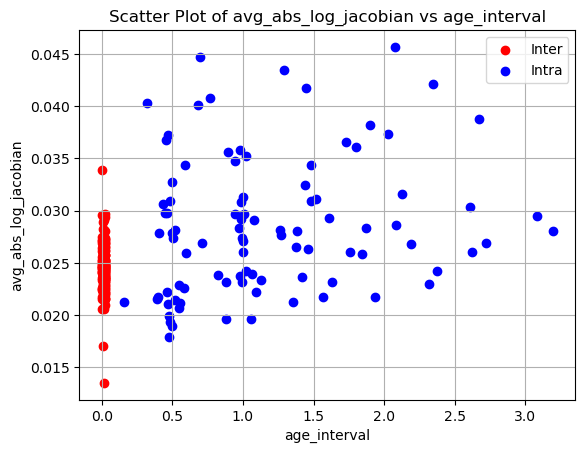

In [46]:
import matplotlib.pyplot as plt
# Filter data based on the 'group' column
group_inter = df_279[df_279['group'] == 'inter']
group_intra = df_279[df_279['group'] == 'intra']
print(np.mean(group_inter), np.std(group_inter))
print(np.mean(group_intra), np.std(group_intra))

# Scatter plot for 'inter' group in red color and 'intra' group in blue color
plt.scatter(group_inter['age_interval'], group_inter['avg_abs_log_jacobian'], c='red', label='Inter')
plt.scatter(group_intra['age_interval'], group_intra['avg_abs_log_jacobian'], c='blue', label='Intra')

plt.title('Scatter Plot of avg_abs_log_jacobian vs age_interval')
plt.xlabel('age_interval')
plt.ylabel('avg_abs_log_jacobian')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
data

,scan_id_1,scan_id_2,age_interval,avg_abs_log_jacobian,group
0,PS15_041,PS14_134,0.0222,0.022083,inter
1,PS14_073,PS15_079,0.0028,0.025215,inter
2,PS15_127,PS14_134,0.0028,0.021543,inter
3,PS14_134,PS16_009,1.0194,0.035245,intra
4,PS16_009,PS16_028,0.0084,0.025440,inter
...,...,...,...,...,...
274,PS14_111,PS14_005,0.0028,0.027106,inter
275,PS14_079,PS16_045,1.6111,0.029255,intra
276,PS14_046,PS17_018,3.0805,0.029481,intra
277,PS16_001,PS16_034,0.0167,0.021835,inter


In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_joint_plot(data, y, x_axis_title, title):
    # Create a joint plot
    joint = sns.jointplot(
        x='age_interval',
        y=y,
        data=data,
        hue='group',
        # kind='kde',
        palette={"intra": "#EC7016", "inter": "#35646E"},
        # height=8
        # common_norm=False
    )
    # Set new labels for x and y axes
    # joint.set_axis_labels('Age Interval', joint.set_axis_labels('Age Interval', 'Average Absolute Log Jacobian Value'))
    joint.set_axis_labels('Age Interval', x_axis_title, fontweight='bold')
    joint.ax_joint.grid(True)
    joint.ax_joint.set_axisbelow(True)

    # Add minor ticks to both x and y axes
    joint.ax_joint.minorticks_on()

    # joint.ax_joint.set_xlabel(fontweight='bold')
    # joint.ax_joint.set_ylabel(fontweight='bold')

    # Set the legend name to 'Pair Type'
    joint.ax_joint.legend(title='Pair Type')
    # plt.suptitle(title)

    return joint





In [187]:
create_joint_plot(df_279_no_overlap, 'avg_log_jacobian', 'Average Log Jacobian Value')

TypeError: create_joint_plot() missing 1 required positional argument: 'title'

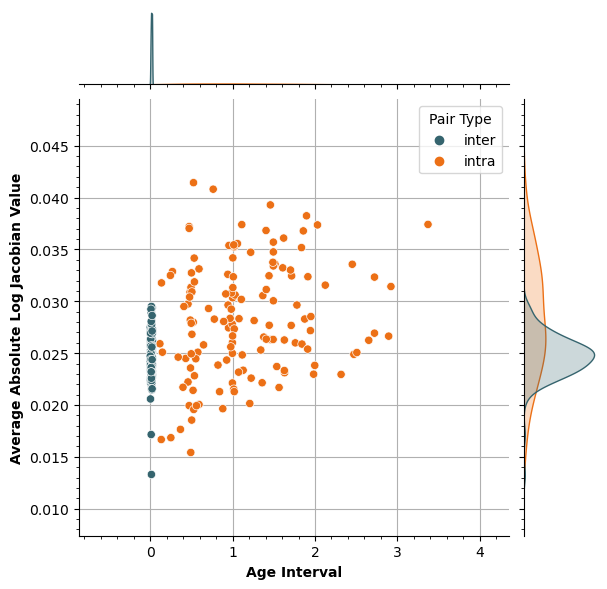

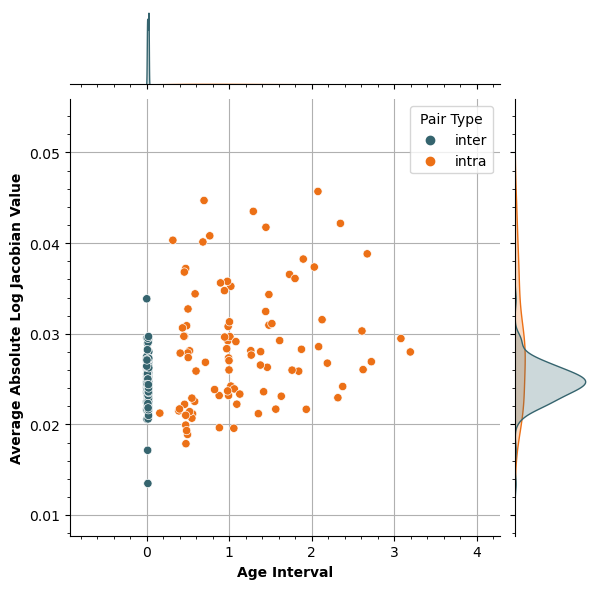

In [191]:

# Assuming you have a figure with two subplots arranged in one row and two columns
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
# plt.sca(axs[0])  # Set the current axis to the first subplot
o = create_joint_plot(df_279_overlap, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'Overlap')
# plt.title('Overlap')

# Second subplot
# plt.sca(axs[1])  # Set the current axis to the second subplot
n_o = create_joint_plot(df_279_no_overlap, 'avg_abs_log_jacobian', 'Average Absolute Log Jacobian Value', 'No Overlap')
# plt.title('No Overlap')

# plt.tight_layout()  # Adjust layout
# plt.show()

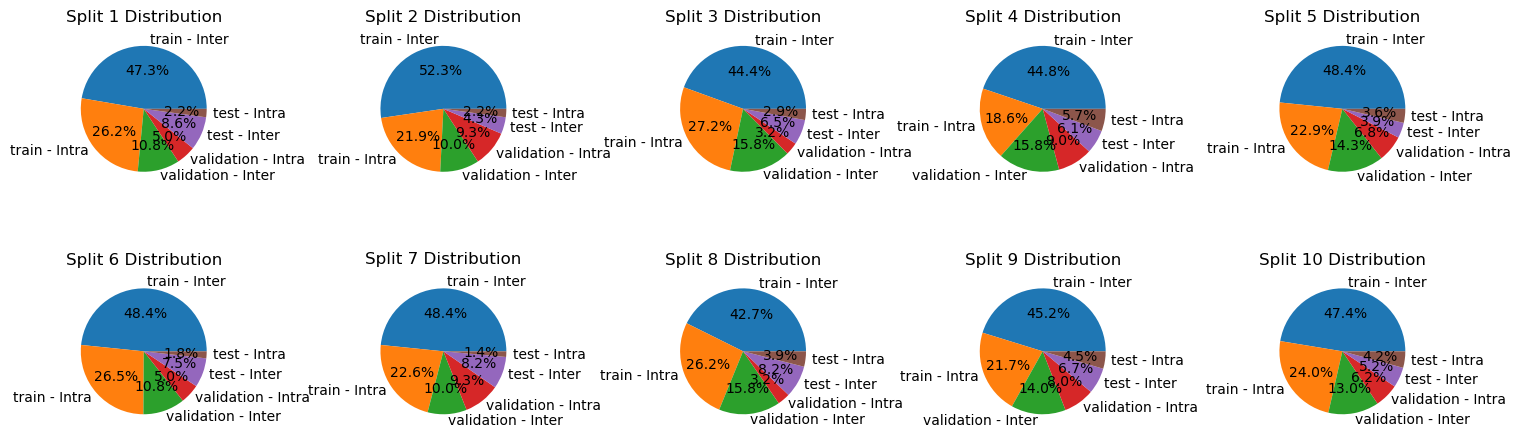

In [63]:
import matplotlib.pyplot as plt

# Example counts for 'intra' and 'inter' for each split
splits_counts_no_overlap = [
    {'train': {'inter': 132, 'intra': 73}, 'validation': {'inter': 30, 'intra': 14}, 'test': {'inter': 24, 'intra': 6}},
    {'train': {'inter': 146, 'intra': 61}, 'validation': {'inter': 28, 'intra': 26}, 'test': {'inter': 12, 'intra': 6}},
    {'train': {'inter': 124, 'intra': 76}, 'validation': {'inter': 44, 'intra': 9}, 'test': {'inter': 18, 'intra': 8}},
    {'train': {'inter': 125, 'intra': 52}, 'validation': {'inter': 44, 'intra': 25}, 'test': {'inter': 17, 'intra': 16}},
    {'train': {'inter': 135, 'intra': 64}, 'validation': {'inter': 40, 'intra': 19}, 'test': {'inter': 11, 'intra': 10}},
    {'train': {'inter': 135, 'intra': 74}, 'validation': {'inter': 30, 'intra': 14}, 'test': {'inter': 21, 'intra': 5}},
    {'train': {'inter': 135, 'intra': 63}, 'validation': {'inter': 28, 'intra': 26}, 'test': {'inter': 23, 'intra': 4}},
    {'train': {'inter': 119, 'intra': 73}, 'validation': {'inter': 44, 'intra': 9}, 'test': {'inter': 23, 'intra': 11}},
    {'train': {'inter': 142, 'intra': 68}, 'validation': {'inter': 44, 'intra': 25}, 'test': {'inter': 21, 'intra': 14}},
    {'train': {'inter': 146, 'intra': 74}, 'validation': {'inter': 40, 'intra': 19}, 'test': {'inter': 16, 'intra': 13}}
]

# Initialize a list to store pie chart data for each split
pie_data = []

# Create pie chart data for each split
for split_count in splits_counts:
    data = []
    labels = []
    for dataset, counts in split_count.items():
        data.extend([counts['inter'], counts['intra']])
        labels.extend([f'{dataset} - Inter', f'{dataset} - Intra'])
    pie_data.append((data, labels))

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for idx, (data, labels) in enumerate(pie_data):
    ax = axs.flatten()[idx]
    ax.pie(data, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Split {idx+1} Distribution')

plt.tight_layout()
plt.show()


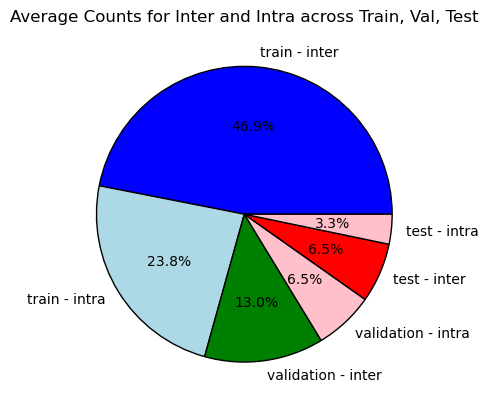

In [65]:
from collections import Counter
# Calculate total counts for each set over all 10 splits
totals = {'train': Counter(), 'validation': Counter(), 'test': Counter()}
num_splits = len(splits_counts)
for split_count in splits_counts:
    for dataset, counts in split_count.items():
        for key in counts:
            totals[dataset][key] += counts[key]

# Plotting the total counts in a pie chart
fig, ax = plt.subplots()
labels = []
sizes = []
colors = []
# Calculate average counts for each set
average_counts = {dataset: {key: count / num_splits for key, count in counts.items()} for dataset, counts in totals.items()}

for dataset, counts in average_counts.items():
    for key, value in counts.items():
        labels.append(f'{dataset} - {key}')
        sizes.append(value)
        if key == 'intra':
            if dataset == 'train':
                colors.append('lightblue')
            elif dataset == 'val':
                colors.append('lightgreen')
            else:
                colors.append('#FFC0CB')  # Custom color for other 'intra' segments
        else:
            if dataset == 'train':
                colors.append('blue')
            elif dataset == 'validation':
                colors.append('green')
            else:
                colors.append('red') 
              # Default color for 'inter'

# Create the pie chart
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Loop through wedges and set their edge color
for wedge in wedges:
    wedge.set_edgecolor('black')

ax.set_title('Average Counts for Inter and Intra across Train, Val, Test')
plt.show()

In [166]:
# Example counts for 'intra' and 'inter' for each split
splits_counts_no_overlap = [
    {'Train': {'inter': 132, 'intra': 73}, 'Validation': {'inter': 30, 'intra': 14}, 'Test': {'inter': 24, 'intra': 6}},
    {'Train': {'inter': 146, 'intra': 61}, 'Validation': {'inter': 28, 'intra': 26}, 'Test': {'inter': 12, 'intra': 6}},
    {'Train': {'inter': 124, 'intra': 76}, 'Validation': {'inter': 44, 'intra': 9}, 'Test': {'inter': 18, 'intra': 8}},
    {'Train': {'inter': 125, 'intra': 52}, 'Validation': {'inter': 44, 'intra': 25}, 'Test': {'inter': 17, 'intra': 16}},
    {'Train': {'inter': 135, 'intra': 64}, 'Validation': {'inter': 40, 'intra': 19}, 'Test': {'inter': 11, 'intra': 10}},
    {'Train': {'inter': 135, 'intra': 74}, 'Validation': {'inter': 30, 'intra': 14}, 'Test': {'inter': 21, 'intra': 5}},
    {'Train': {'inter': 135, 'intra': 63}, 'Validation': {'inter': 28, 'intra': 26}, 'Test': {'inter': 23, 'intra': 4}},
    {'Train': {'inter': 119, 'intra': 73}, 'Validation': {'inter': 44, 'intra': 9}, 'Test': {'inter': 23, 'intra': 11}},
    {'Train': {'inter': 142, 'intra': 68}, 'Validation': {'inter': 44, 'intra': 25}, 'Test': {'inter': 21, 'intra': 14}},
    {'Train': {'inter': 146, 'intra': 74}, 'Validation': {'inter': 40, 'intra': 19}, 'Test': {'inter': 16, 'intra': 13}}
]

splits_counts_overlap = [
    {'Train': {'inter': 88, 'intra': 87}, 'Validation': {'inter': 40, 'intra': 36}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 92, 'intra': 83}, 'Validation': {'inter': 42, 'intra': 34}, 'Test': {'inter': 14, 'intra': 14}},
    {'Train': {'inter': 124, 'intra': 76}, 'Validation': {'inter': 41, 'intra': 35}, 'Test': {'inter': 14, 'intra': 14}},
    {'Train': {'inter': 125, 'intra': 52}, 'Validation': {'inter': 44, 'intra': 32}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 135, 'intra': 64}, 'Validation': {'inter': 42, 'intra': 34}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 135, 'intra': 74}, 'Validation': {'inter': 38, 'intra': 38}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 135, 'intra': 63}, 'Validation': {'inter': 39, 'intra': 37}, 'Test': {'inter': 17, 'intra': 11}},
    {'Train': {'inter': 119, 'intra': 73}, 'Validation': {'inter': 39, 'intra': 37}, 'Test': {'inter': 15, 'intra': 13}},
    {'Train': {'inter': 142, 'intra': 68}, 'Validation': {'inter': 38, 'intra': 38}, 'Test': {'inter': 16, 'intra': 12}},
    {'Train': {'inter': 146, 'intra': 74}, 'Validation': {'inter': 40, 'intra': 36}, 'Test': {'inter': 14, 'intra': 13}}
]

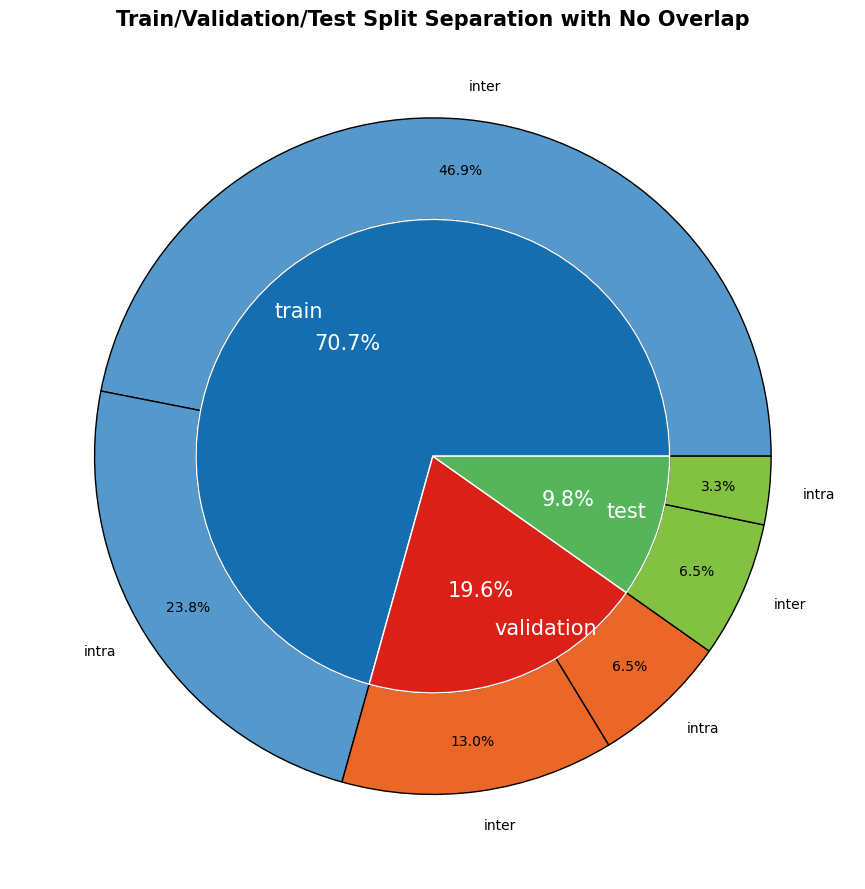

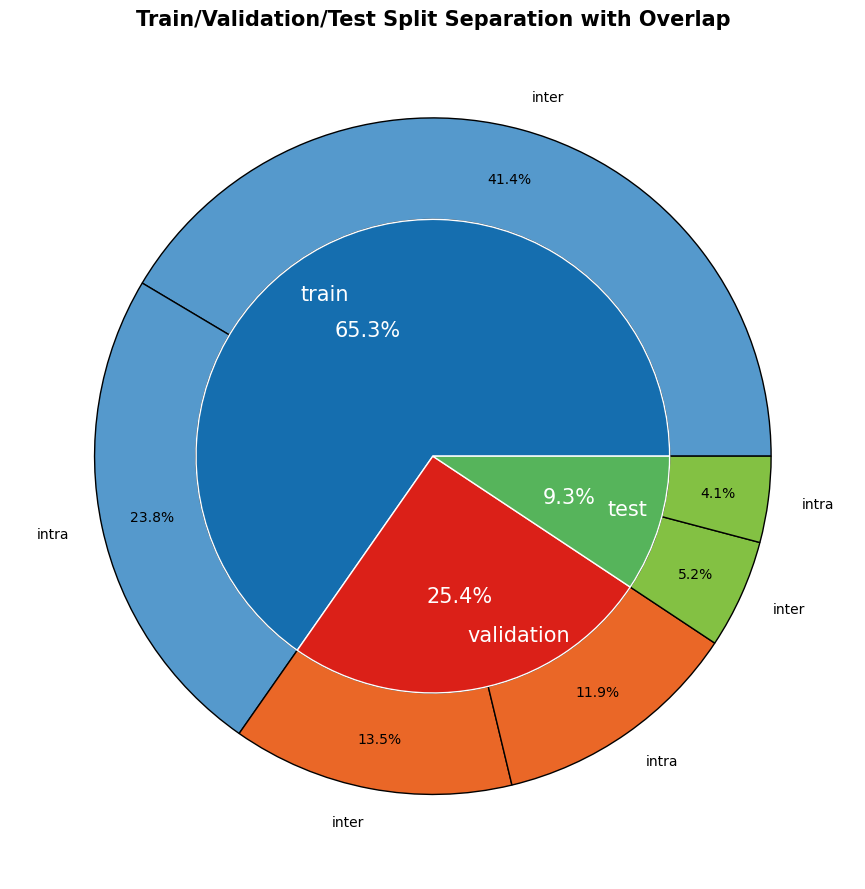

In [99]:
for splits_counts in [splits_counts_no_overlap, splits_counts_overlap]:
    # Calculate the average total counts for train, val, and test
    total_counts = {'train': 0, 'validation': 0, 'test': 0}
    for data in splits_counts:
        for key in data:
            total_counts[key] += data[key]['inter'] + data[key]['intra']
    for key in total_counts:
        total_counts[key] /= len(splits_counts)

    # Calculate the average inter and intra values per each set (train, val, test)
    avg_inter = {'train': 0, 'validation': 0, 'test': 0}
    avg_intra = {'train': 0, 'validation': 0, 'test': 0}

    for data in splits_counts:
        for category in avg_inter:
            avg_inter[category] += data[category]['inter']
            avg_intra[category] += data[category]['intra']

    for category in avg_inter:
        avg_inter[category] /= len(splits_counts)
        avg_intra[category] /= len(splits_counts)

    # Create lists of the calculated averages
    inter_values = [avg_inter[key] for key in avg_inter]
    intra_values = [avg_intra[key] for key in avg_intra]

    interleaved = [val for pair in zip(inter_values, intra_values) for val in pair]
    labels_outer = 3*['inter','intra']

    fig, ax = plt.subplots(figsize=(12, 9))

    inner_colors = ['#156EAF', '#DB2018', '#56B45B']
    outer_colors_single = ['#5599CC', '#EA6727', '#83C143']
    outer_colors = np.repeat(outer_colors_single, 2)
    size = 0.3
    r = 1

    # Generating pie charts
    ax.pie(interleaved, labels=labels_outer, radius=r,
        colors=outer_colors, wedgeprops=dict(width=size, edgecolor='k'), autopct='%1.1f%%', pctdistance=0.85)
    ax.pie([total_counts['train'], total_counts['validation'], total_counts['test']],labels=total_counts.keys() , radius=r - size, colors=inner_colors,
        labeldistance=0.77, textprops=dict(color='w', fontsize=15), wedgeprops=dict(edgecolor='w'), autopct='%1.1f%%')#, pctdistance=0.85)
    
    # Set the title for each pie chart
    # Set the title for each pie chart
    title_text = 'Train/Validation/Test Split Separation with No Overlap' if splits_counts == splits_counts_no_overlap else 'Train/Validation/Test Split Separation with Overlap'
    ax.set_title(title_text, fontsize=15, fontdict={'weight': 'bold'})

    plt.tight_layout()
    plt.show()

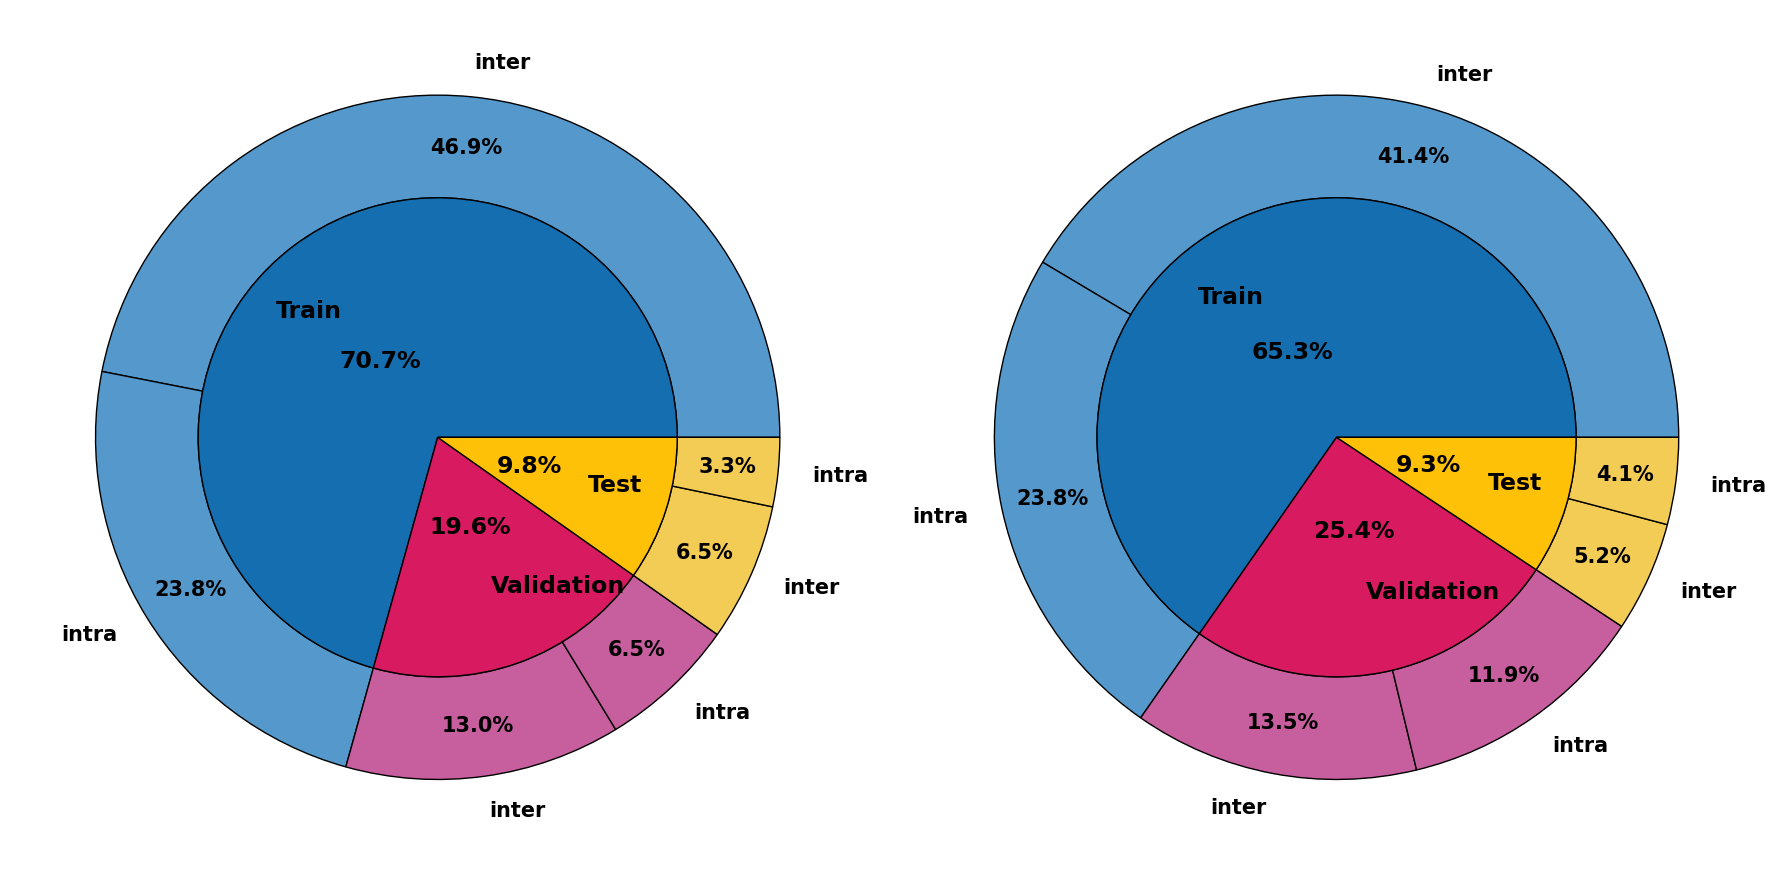

In [172]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

for index, splits_counts in enumerate([splits_counts_no_overlap, splits_counts_overlap]):
    # Calculate the average total counts for train, val, and test
    total_counts = {'Train': 0, 'Validation': 0, 'Test': 0}
    for data in splits_counts:
        for key in data:
            total_counts[key] += data[key]['inter'] + data[key]['intra']
    for key in total_counts:
        total_counts[key] /= len(splits_counts)

    # Calculate the average inter and intra values per each set (train, val, test)
    avg_inter = {'Train': 0, 'Validation': 0, 'Test': 0}
    avg_intra = {'Train': 0, 'Validation': 0, 'Test': 0}

    for data in splits_counts:
        for category in avg_inter:
            avg_inter[category] += data[category]['inter']
            avg_intra[category] += data[category]['intra']

    for category in avg_inter:
        avg_inter[category] /= len(splits_counts)
        avg_intra[category] /= len(splits_counts)

    # Create lists of the calculated averages
    inter_values = [avg_inter[key] for key in avg_inter]
    intra_values = [avg_intra[key] for key in avg_intra]

    interleaved = [val for pair in zip(inter_values, intra_values) for val in pair]
    labels_outer = 3*['inter','intra']

    inner_colors = ['#156EAF', '#D81B60', '#FFC107']
    outer_colors_single = ['#5599CC', '#C75E9E', '#F3CC56']
    outer_colors = np.repeat(outer_colors_single, 2)
    size = 0.3
    r = 1

    # Generating pie charts
    ax = axs[index]
    ax.pie(interleaved, labels=labels_outer, radius=r,
           colors=outer_colors, wedgeprops=dict(width=size, edgecolor='k'), autopct='%1.1f%%', textprops=dict(color='k', fontsize=15, fontweight='bold'), pctdistance=0.85)
    ax.pie([total_counts['Train'], total_counts['Validation'], total_counts['Test']], labels=total_counts.keys(), radius=r - size, colors=inner_colors,
           labeldistance=0.659, textprops=dict(color='k', fontsize=17, fontweight='bold'), wedgeprops=dict(edgecolor='k'), autopct='%1.1f%%', pctdistance=0.4)

    # Set the title for each pie chart
    # title_text = 'Train/Validation/Test Split Separation with No Overlap' if splits_counts == splits_counts_no_overlap else 'Train/Validation/Test Split Separation with Overlap'
    # ax.set_title(title_text, fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


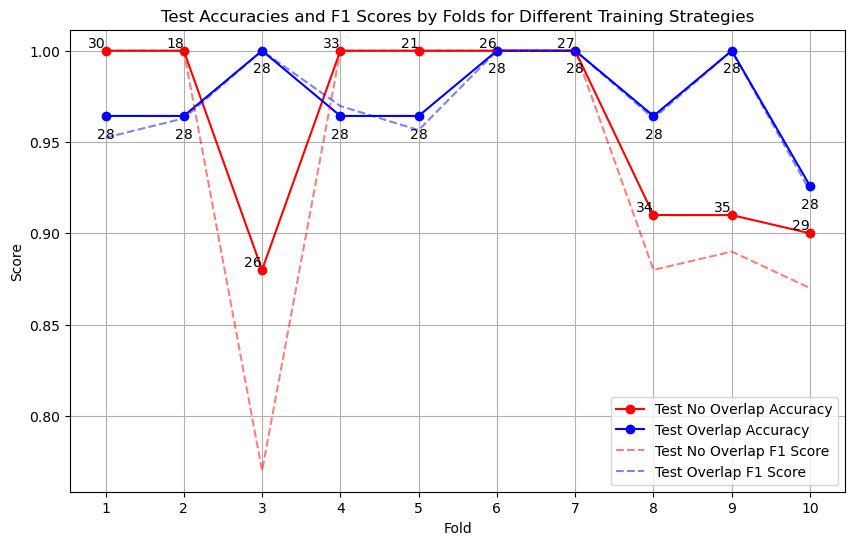

In [82]:
test_no_overlap_acc = [ 1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [ 1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [ 30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10*[28]

plt.figure(figsize=(10, 6))

plt.plot(test_no_overlap_acc, 'ro-', label='Test No Overlap Accuracy')
plt.plot(test_overlap_acc, 'bo-', label='Test Overlap Accuracy')

plt.plot(test_no_overlap_f1, 'r--', label='Test No Overlap F1 Score', alpha=0.5)
plt.plot(test_overlap_f1, 'b--', label='Test Overlap F1 Score', alpha=0.5)

for x, y in zip(range(10), test_no_overlap_acc):
    plt.text(x, y+0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    plt.text(x, y-0.006, str(test_qty_overlap[x]), ha='center', va='top')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Test Accuracies and F1 Scores by Folds for Different Training Strategies')
plt.xticks(range(10), [str(i+1) for i in range(10)])
plt.legend()
plt.grid(True)
plt.show()




In [163]:
[str(i+1) for i in range(10)]

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

[0.96, 0.975, 0.941, 0.973]
0.04959838707054897 0.02341269841269841 0.07841555968046138 0.02513326730429045


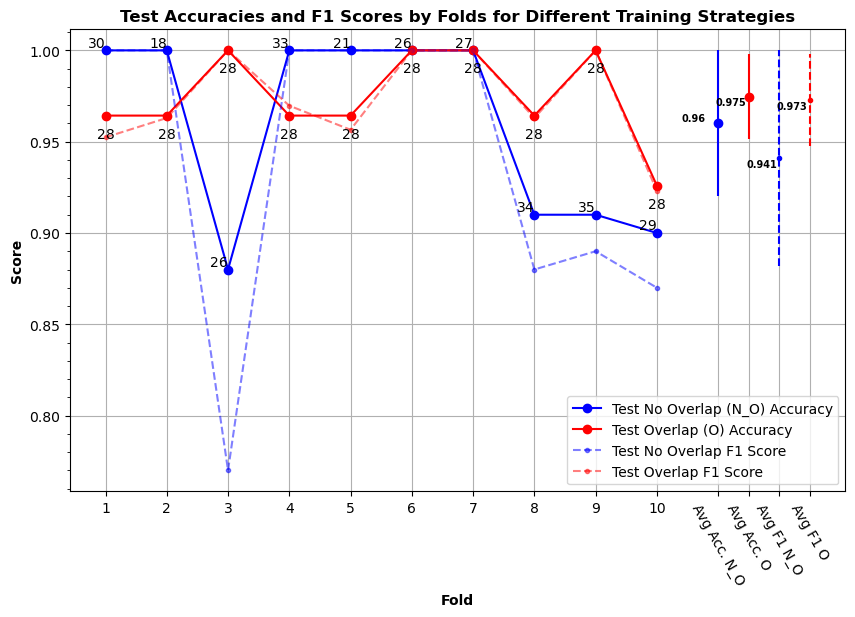

In [179]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10 * [28]

# plt.figure(figsize=(10, 6))

plt.plot(test_no_overlap_acc, 'bo-', label='Test No Overlap (N_O) Accuracy')
plt.plot(test_overlap_acc, 'ro-', label='Test Overlap (O) Accuracy')

plt.plot(test_no_overlap_f1, 'b.--', label='Test No Overlap F1 Score', alpha=0.5)
plt.plot(test_overlap_f1, 'r.--', label='Test Overlap F1 Score', alpha=0.5)

# Test No Overlap
avg_no_overlap_acc = np.mean(test_no_overlap_acc)
std_no_overlap_acc = np.std(test_no_overlap_acc)
yerr_no_acc = std_no_overlap_acc if avg_no_overlap_acc + std_no_overlap_acc <= 1 else 1 - avg_no_overlap_acc
eb1 = plt.errorbar(10, avg_no_overlap_acc, yerr=yerr_no_acc, fmt='bo')


avg_no_overlap_f1 = np.mean(test_no_overlap_f1)
std_no_overlap_f1 = np.std(test_no_overlap_f1)
yerr_no_f1 = std_no_overlap_f1 if avg_no_overlap_f1 + std_no_overlap_f1 <= 1 else 1 - avg_no_overlap_f1
eb2 = plt.errorbar(11, avg_no_overlap_f1, yerr=yerr_no_f1, fmt='b.')
eb2[-1][0].set_linestyle('--')

# Test Overlap
avg_overlap_acc = np.mean(test_overlap_acc)
std_overlap_acc = np.std(test_overlap_acc)
plt.errorbar(10.5, avg_overlap_acc, yerr=std_overlap_acc, fmt='ro')

avg_overlap_f1 = np.mean(test_overlap_f1)
std_overlap_f1 = np.std(test_overlap_f1)
# Ensure the error bars don't exceed y=1
yerr_o_f1 = std_overlap_f1 if avg_overlap_f1 + std_overlap_f1 <= 1 else 1 - avg_overlap_f1
eb4 = plt.errorbar(11.5, avg_overlap_f1, yerr=yerr_o_f1, fmt='r.')
eb4[-1][0].set_linestyle('--')

for x, y in zip(range(10), test_no_overlap_acc):
    plt.text(x, y + 0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    plt.text(x, y - 0.006, str(test_qty_overlap[x]), ha='center', va='top')

# Determine the y-axis ticks
# y_ticks = plt.gca().get_yticks()
ro = 3
y_avg_values = [np.round(np.mean(test_no_overlap_acc),ro), np.round(np.mean(test_overlap_acc),ro), np.round(np.mean(test_no_overlap_f1),ro), np.round(np.mean(test_overlap_f1),ro)]
print(y_avg_values)
print(std_no_overlap_acc, std_overlap_acc, std_no_overlap_f1, std_overlap_f1)

plt.text(10- 0.4, y_avg_values[0], str(y_avg_values[0]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(10.5- 0.29, y_avg_values[1] - 0.006, str(y_avg_values[1]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(11- 0.29, y_avg_values[2] - 0.006, str(y_avg_values[2]), ha='center', va='bottom', fontsize=7, weight='bold')
plt.text(11.5- 0.29, y_avg_values[3] - 0.006, str(y_avg_values[3]), ha='center', va='bottom', fontsize=7, weight='bold')
# y_tick_labels = [f'{val:.2f}' for val in y_ticks] + [f'{val:.2f}' for val in y_avg_values]
# # Set specific y-axis ticks and labels
# plt.yticks(np.concatenate([y_ticks, y_avg_values]), y_tick_labels)

plt.xlabel('Fold', weight='bold')
plt.ylabel('Score', weight='bold')
plt.title('Test Accuracies and F1 Scores by Folds for Different Training Strategies', weight='bold')
plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,10.5,11,11.5], [str(i+1) for i in range(10)] + ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'])
# Rotate specific labels by -60 degrees
plt.setp(plt.gca().get_xticklabels()[-4:], rotation=-60, ha="center")
plt.legend(loc='lower right')
# Currently, there are no minor ticks,
#   so trying to make them visible would have no effect
ax.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.grid(True)
plt.show()


[0.96, 0.975, 0.941, 0.973]
0.04959838707054897 0.02341269841269841 0.07841555968046138 0.02513326730429045


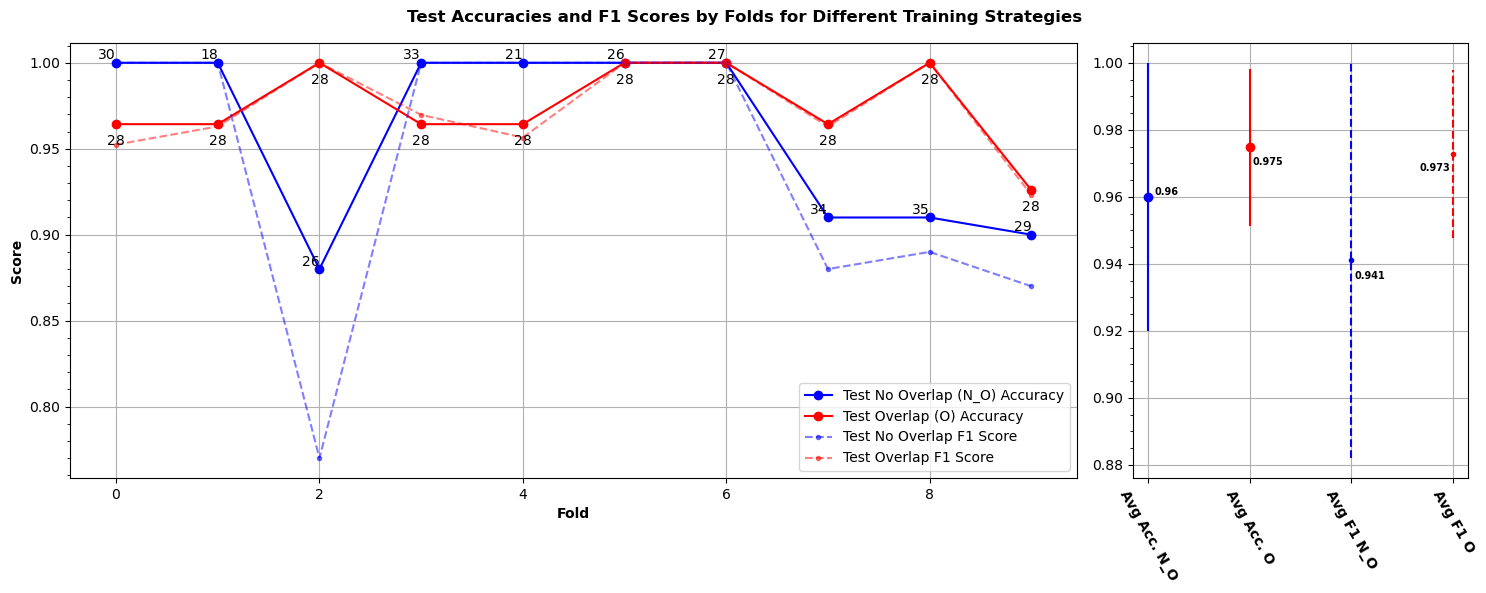

In [219]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_qty_no_overlap = [30, 18, 26, 33, 21, 26, 27, 34, 35, 29]

test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]
test_qty_overlap = 10 * [28]

# plt.figure(figsize=(10, 6))

ax1.plot(test_no_overlap_acc, 'bo-', label='Test No Overlap (N_O) Accuracy')
ax1.plot(test_overlap_acc, 'ro-', label='Test Overlap (O) Accuracy')

ax1.plot(test_no_overlap_f1, 'b.--', label='Test No Overlap F1 Score', alpha=0.5)
ax1.plot(test_overlap_f1, 'r.--', label='Test Overlap F1 Score', alpha=0.5)

# Test No Overlap
avg_no_overlap_acc = np.mean(test_no_overlap_acc)
std_no_overlap_acc = np.std(test_no_overlap_acc)
yerr_no_acc = std_no_overlap_acc if avg_no_overlap_acc + std_no_overlap_acc <= 1 else 1 - avg_no_overlap_acc
eb1 = ax2.errorbar(1, avg_no_overlap_acc, yerr=yerr_no_acc, fmt='bo')


avg_no_overlap_f1 = np.mean(test_no_overlap_f1)
std_no_overlap_f1 = np.std(test_no_overlap_f1)
yerr_no_f1 = std_no_overlap_f1 if avg_no_overlap_f1 + std_no_overlap_f1 <= 1 else 1 - avg_no_overlap_f1
eb2 = ax2.errorbar(2, avg_no_overlap_f1, yerr=yerr_no_f1, fmt='b.')
eb2[-1][0].set_linestyle('--')

# Test Overlap
avg_overlap_acc = np.mean(test_overlap_acc)
std_overlap_acc = np.std(test_overlap_acc)
ax2.errorbar(1.5, avg_overlap_acc, yerr=std_overlap_acc, fmt='ro')

avg_overlap_f1 = np.mean(test_overlap_f1)
std_overlap_f1 = np.std(test_overlap_f1)
# Ensure the error bars don't exceed y=1
yerr_o_f1 = std_overlap_f1 if avg_overlap_f1 + std_overlap_f1 <= 1 else 1 - avg_overlap_f1
eb4 = ax2.errorbar(2.5, avg_overlap_f1, yerr=yerr_o_f1, fmt='r.')
eb4[-1][0].set_linestyle('--')

for x, y in zip(range(10), test_no_overlap_acc):
    ax1.text(x, y + 0.002, str(test_qty_no_overlap[x]), ha='right')

for x, y in zip(range(10), test_overlap_acc):
    ax1.text(x, y - 0.006, str(test_qty_overlap[x]), ha='center', va='top')

# Determine the y-axis ticks
# y_ticks = plt.gca().get_yticks()
ro = 3
y_avg_values = [np.round(np.mean(test_no_overlap_acc),ro), np.round(np.mean(test_overlap_acc),ro), np.round(np.mean(test_no_overlap_f1),ro), np.round(np.mean(test_overlap_f1),ro)]
print(y_avg_values)
print(std_no_overlap_acc, std_overlap_acc, std_no_overlap_f1, std_overlap_f1)

ax2.text(1+ 0.09, y_avg_values[0], str(y_avg_values[0]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(1.5+ 0.09, y_avg_values[1] - 0.006, str(y_avg_values[1]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(2+ 0.09, y_avg_values[2] - 0.006, str(y_avg_values[2]), ha='center', va='bottom', fontsize=7, weight='bold')
ax2.text(2.5- 0.09, y_avg_values[3] - 0.006, str(y_avg_values[3]), ha='center', va='bottom', fontsize=7, weight='bold')
# y_tick_labels = [f'{val:.2f}' for val in y_ticks] + [f'{val:.2f}' for val in y_avg_values]
# # Set specific y-axis ticks and labels
# plt.yticks(np.concatenate([y_ticks, y_avg_values]), y_tick_labels)

ax1.set_xlabel('Fold', weight='bold')
ax1.set_ylabel('Score', weight='bold')
plt.suptitle('Test Accuracies and F1 Scores by Folds for Different Training Strategies', weight='bold')
# plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,10.5,11,11.5], [str(i+1) for i in range(10)] + ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'])
# Rotate specific labels by -60 degrees
# plt.setp(plt.gca().get_xticklabels()[-4:], rotation=-60, ha="center")
ax1.legend(loc='lower right')
ax2.set_xticks([1,1.5,2,2.5], ['Avg Acc. N_O', 'Avg Acc. O', 'Avg F1 N_O', 'Avg F1 O'], rotation=-60, weight='bold')
# Currently, there are no minor ticks,
#   so trying to make them visible would have no effect
ax1.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax1.minorticks_on()
ax2.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax2.xaxis.set_tick_params(which='minor', bottom=False)
ax2.grid(True)
ax1.grid(True)
fig.tight_layout()
plt.show()


1.0


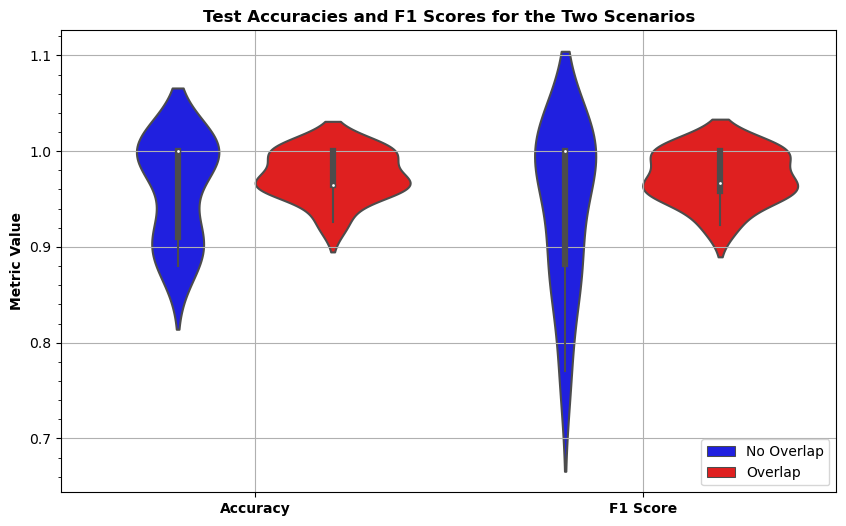

In [217]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Existing data
test_no_overlap_acc = [1.0, 1.0, 0.88, 1.0, 1.0, 1.0, 1.0, 0.91, 0.91, 0.90]
test_no_overlap_f1 = [1, 1, 0.77, 1, 1, 1, 1, 0.88, 0.89, 0.87]
test_overlap_acc = [0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143, 0.9642857142857143, 1.0, 1.0, 0.9642857142857143, 1.0, 0.9259259259259259]
test_overlap_f1 = [0.9523809523809523, 0.962962962962963, 1.0, 0.9696969696969697, 0.9565217391304348, 1.0, 1.0, 0.962962962962963, 1.0, 0.9230769230769231]

# Combine the data into a DataFrame
data = {
    'Test Type': ['Accuracy'] * 10 + ['F1 Score'] * 10 + ['Accuracy'] * 10 + ['F1 Score'] * 10,
    'Scores': test_no_overlap_acc + test_no_overlap_f1 + test_overlap_acc + test_overlap_f1,
    'Scenario': ['No Overlap']*20 + ['Overlap']*20
}

print(np.median(test_no_overlap_acc))
df = pd.DataFrame(data)
# print(df)

# Plot using Seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='Test Type', y='Scores', data=df, hue='Scenario', notch=True, showcaps=False, medianprops={"color": "k", "linewidth": 2}, palette={"No Overlap": "blue", "Overlap": "red"}).set(xlabel=None) #,
            # flierprops={"marker": "x"},
            # boxprops={"facecolor": (.3, .5, .7, .5)},
            # medianprops={"color": "r", "linewidth": 2},
            # palette={"No Overlap Accuracy": "blue", "No Overlap F1 Score": "blue",
            #          "Overlap Accuracy": "red", "Overlap F1 Score": "red"})

plt.ylabel('Metric Value', weight='bold')
plt.title('Test Accuracies and F1 Scores for the Two Scenarios', weight='bold')
plt.xticks(weight='bold')
#   so trying to make them visible would have no effect
ax.yaxis.get_ticklocs(minor=True) 
# Initialize minor ticks
ax.minorticks_on()

# Now minor ticks exist and are turned on for both axes

# Turn off x-axis minor ticks
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()
